<a href="https://colab.research.google.com/github/docling-project/docling/blob/main/docs/examples/visual_grounding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visual grounding

| Step | Tech | Execution |
| --- | --- | --- |
| Embedding | Hugging Face / Sentence Transformers | 💻 Local |
| Vector store | Milvus | 💻 Local |
| Gen AI | Hugging Face Inference API | 🌐 Remote |

This example showcases Docling's **visual grounding** capabilities, which can be combined
with any agentic AI / RAG framework.

In this instance, we illustrate these capabilities leveraging the
[LangChain Docling integration](../../integrations/langchain/), along with a Milvus
vector store, as well as sentence-transformers embeddings.

## Setup

- 👉 For best conversion speed, use GPU acceleration whenever available; e.g. if running on Colab, use GPU-enabled runtime.
- Notebook uses HuggingFace's Inference API; for increased LLM quota, token can be provided via env var `HF_TOKEN`.
- Requirements can be installed as shown below (`--no-warn-conflicts` meant for Colab's pre-populated Python env; feel free to remove for stricter usage):

In [2]:
%pip install -q --progress-bar off --no-warn-conflicts langchain-docling langchain-core langchain-huggingface langchain_milvus langchain matplotlib python-dotenv

In [39]:
import os
from pathlib import Path
from tempfile import mkdtemp

from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_docling.loader import ExportType


def _get_env_from_colab_or_os(key):
    try:
        from google.colab import userdata

        try:
            return userdata.get(key)
        except userdata.SecretNotFoundError:
            pass
    except ImportError:
        pass
    return os.getenv(key)


load_dotenv()

# https://github.com/huggingface/transformers/issues/5486:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

HF_TOKEN = _get_env_from_colab_or_os("HF_TOKEN")
SOURCES = [
    "data/Sample_PO-1.1 Approval_BBU_payment terms.pdf",
    "data/Sample_PO-1.2 (T&C for_mobilization_advance).pdf",
    "data/Sample_PO-1.3 (Payment terms_PI_removed).pdf",
    "data/Sample_PO-1.4 (SAP PO text).pdf",
]  # Docling Technical Report
# EMBED_MODEL_ID = "google/embeddinggemma-300m"
EMBED_MODEL_ID = "text-embedding-3-small"
GEN_MODEL_ID = "mistralai/Mixtral-8x7B-Instruct-v0.1"
QUESTION = "Search for a deferment clause which could have the phrase 'no need to withhold any amount' or some equivalent of it. If exits answer yes and provide the statement."
PROMPT = PromptTemplate.from_template(
    "Context information is below.\n---------------------\n{context}\n---------------------\nGiven the context information and not prior knowledge, answer the query.\nQuery: {input}\nAnswer:\n",
)
TOP_K = 4
MILVUS_URI = str(Path(mkdtemp()) / "docling.db")

## Document store setup



## Document loading

We first define our converter, in this case including options for keeping page images (for visual grounding).

In [40]:
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions, RapidOcrOptions
from docling.document_converter import DocumentConverter, PdfFormatOption

download_path = "models"

# Setup RapidOcrOptions for English detection
det_model_path = os.path.join(
    download_path, "ch_PP-OCRv5_server_det.onnx"
)
rec_model_path = os.path.join(
    download_path, "ch_PP-OCRv5_rec_server_infer.onnx"
)
cls_model_path = os.path.join(
    download_path, "ch_ppocr_mobile_v2.0_cls_infer.onnx"
)
font_path = "fonts/FZYTK.TTF"

ocr_options = RapidOcrOptions(
    det_model_path=det_model_path,
    rec_model_path=rec_model_path,
    cls_model_path=cls_model_path,
    font_path=font_path,
)

converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=PdfPipelineOptions(
                ocr_options=ocr_options,
                generate_page_images=True,
                images_scale=2.0,
            ),
        )
    }
)

We set up a simple doc store for keeping converted documents, as that is needed for visual grounding further below.

In [41]:
doc_store = {}
doc_store_root = Path(mkdtemp())
for source in SOURCES:
    dl_doc = converter.convert(source=source).document
    file_path = Path(doc_store_root / f"{dl_doc.origin.binary_hash}.json")
    dl_doc.save_as_json(file_path)
    doc_store[dl_doc.origin.binary_hash] = file_path

2025-11-24 08:16:44,719 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-11-24 08:16:44,775 - INFO - Going to convert document batch...
2025-11-24 08:16:44,778 - INFO - Initializing pipeline for StandardPdfPipeline with options hash 35a81e8ff0caf54ddcb46ceb344850c2
2025-11-24 08:16:44,793 - INFO - Accelerator device: 'mps'
[INFO] 2025-11-24 08:16:44,819 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-11-24 08:16:44,826 [RapidOCR] main.py:53: Using models/ch_PP-OCRv5_server_det.onnx
[INFO] 2025-11-24 08:16:45,076 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-11-24 08:16:45,077 [RapidOCR] main.py:53: Using models/ch_ppocr_mobile_v2.0_cls_infer.onnx
[INFO] 2025-11-24 08:16:45,107 [RapidOCR] base.py:22: Using engine_name: onnxruntime
[INFO] 2025-11-24 08:16:45,108 [RapidOCR] main.py:53: Using models/ch_PP-OCRv5_rec_server_infer.onnx
2025-11-24 08:16:45,289 - INFO - Accelerator device: 'mps'
2025-11-24 08:16:54,741 - INFO - Accelerator device:

In [42]:
dl_doc.__dict__.keys()

dict_keys(['schema_name', 'version', 'name', 'origin', 'furniture', 'body', 'groups', 'texts', 'pictures', 'tables', 'key_value_items', 'form_items', 'pages'])

Now we can instantiate our loader and load documents.

In [52]:
from langchain_docling import DoclingLoader

from docling.chunking import HybridChunker

import tiktoken
from docling_core.transforms.chunker.tokenizer.openai import OpenAITokenizer

tokenizer = OpenAITokenizer(
    tokenizer=tiktoken.encoding_for_model("text-embedding-3-small"),
    max_tokens=2048,  # context window length required for OpenAI tokenizers
)

loader = DoclingLoader(
    file_path=SOURCES,
    converter=converter,
    export_type=ExportType.DOC_CHUNKS,
    chunker=HybridChunker(tokenizer=tokenizer),
)

docs = loader.load()

2025-11-24 08:29:32,148 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-11-24 08:29:32,158 - INFO - Going to convert document batch...
2025-11-24 08:29:32,159 - INFO - Processing document Sample_PO-1.1 Approval_BBU_payment terms.pdf
2025-11-24 08:29:48,889 - INFO - Finished converting document Sample_PO-1.1 Approval_BBU_payment terms.pdf in 16.74 sec.
2025-11-24 08:29:48,900 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-11-24 08:29:48,905 - INFO - Going to convert document batch...
2025-11-24 08:29:48,906 - INFO - Processing document Sample_PO-1.2 (T&C for_mobilization_advance).pdf
2025-11-24 08:30:35,466 - INFO - Finished converting document Sample_PO-1.2 (T&C for_mobilization_advance).pdf in 46.57 sec.
2025-11-24 08:30:35,483 - INFO - detected formats: [<InputFormat.PDF: 'pdf'>]
2025-11-24 08:30:35,487 - INFO - Going to convert document batch...
2025-11-24 08:30:35,488 - INFO - Processing document Sample_PO-1.3 (Payment terms_PI_removed).pdf
2025-11-24 08:30:5

In [53]:
docs[0].__dict__.keys()

dict_keys(['id', 'metadata', 'page_content', 'type'])

> 👉 **NOTE**: As you see above, using the `HybridChunker` can sometimes lead to a warning from the transformers library, however this is a "false alarm" — for details check [here](https://docling-project.github.io/docling/faq/#hybridchunker-triggers-warning-token-indices-sequence-length-is-longer-than-the-specified-maximum-sequence-length-for-this-model).

Inspecting some sample splits:

In [54]:
for d in docs[:3]:
    print(f"- {d.page_content=}")
print("...")

- d.page_content='FORMAT FOR NON-DEDUCTION ON ACCOUNT OF PAYMENT TERMS FOR PAYMENT THROUGH 1VIM.\nProject name :Building Worksfor PP andCDw UnitsIncludingCivilStructural and Architectural Works, Lift, HVAC for PP and CDW Buildings for P-25 Project of IOCL PRPC\nNature of Contract : LSTK/EPEM/CONVETIONAL\nThis is to certify that Service entry sheet has been prepared in SAP as per the payment terms applicable for each item for the above referred Work Order. Records of certified bill are maintained in abstract sheet/billing schedule.\nTherefore, there is no need to withhold any amount from invoices processed at VIM on account of "Payment terms".\nAny amount to be withheld on account of "Payment terms" shall be maintained by EIC in VIM Dash Board as and when same is required.'
- d.page_content='determined and the amount provisionally withheld. Any excess amount provisionally withheld in excess of Price Adjustment finally determined shall upon such determination be paid to the CONTRACTOR. A

## Ingestion

In [55]:
import json
from pathlib import Path
from tempfile import mkdtemp

from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_milvus import Milvus

# embedding = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)

from langchain_openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings(
    model="text-embedding-3-large",
    dimensions=1024,
)

milvus_uri = str(Path(mkdtemp()) / "docling.db")  # or set as needed
vectorstore = Milvus.from_documents(
    documents=docs,
    embedding=embedding,
    collection_name="docling_demo",
    connection_args={"uri": milvus_uri},
    index_params={"index_type": "FLAT", "metric_type": "COSINE"},
    drop_old=True,
)

I0000 00:00:1763953559.922370  196579 fork_posix.cc:71] Other threads are currently calling into gRPC, skipping fork() handlers
python(93713) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
2025-11-24 08:36:02,829 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


## RAG

In [56]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_huggingface import HuggingFaceEndpoint
from langchain_openai import ChatOpenAI

retriever = vectorstore.as_retriever(search_kwargs={"k": TOP_K})
# llm = HuggingFaceEndpoint(
#     repo_id=GEN_MODEL_ID,
#     huggingfacehub_api_token=HF_TOKEN,
# )

llm = ChatOpenAI(
    model="gpt-5-nano",
    # stream_usage=True,
    # temperature=None,
    # max_tokens=None,
    # timeout=None,
    # reasoning_effort="low",
    # max_retries=2,
    api_key=os.getenv("OPENAI_API_KEY"),  # If you prefer to pass api key in directly
    # base_url="...",
    # organization="...",
    # other params...
)

def clip_text(text, threshold=100):
    return f"{text[:threshold]}..." if len(text) > threshold else text

In [57]:
from docling.chunking import DocMeta
from docling.datamodel.document import DoclingDocument

question_answer_chain = create_stuff_documents_chain(llm, PROMPT)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)
resp_dict = rag_chain.invoke({"input": QUESTION})

clipped_answer = clip_text(resp_dict["answer"], threshold=200)
print(f"Question:\n{resp_dict['input']}\n\nAnswer:\n{clipped_answer}")

2025-11-24 08:36:12,185 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-11-24 08:36:18,269 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Question:
Search for a deferment clause which could have the phrase 'no need to withhold any amount' or some equivalent of it. If exits answer yes and provide the statement.

Answer:
Yes. The statement is: 
Therefore, there is no need to withhold any amount from invoices processed at VIM on account of "Payment terms".


### Visual grounding

In [50]:
meta

DocMeta(schema_name='docling_core.transforms.chunker.DocMeta', version='1.0.0', doc_items=[DocItem(self_ref='#/texts/76', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=5, bbox=BoundingBox(l=108.0, t=322.2, r=504.003, b=259.10300000000007, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 543))]), DocItem(self_ref='#/texts/77', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.TEXT: 'text'>, prov=[ProvenanceItem(page_no=5, bbox=BoundingBox(l=108.0, t=251.654, r=504.003, b=199.07799999999997, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 402))])], headings=['6 Future work and contributions'], captions=None, origin=DocumentOrigin(mimetype='application/pdf', binary_hash=11465328351749295394, filename='2408.09869v5.pdf', uri=None))

Source 1:
  text: "FORMAT FOR NON-DEDUCTION ON ACCOUNT OF PAYMENT TERMS FOR PAYMENT THROUGH 1VIM.\nProject name :Building Worksfor PP andCDw UnitsIncludingCivilStructural and Architectural Works, Lift, HVAC for PP and CDW Buildings for P-25 Project of IOCL PRPC\nNature of Contract : LSTK/EPEM/CONVETIONAL\nThis is to certify that Service entry sheet has been prepared in ..."
  page: 1


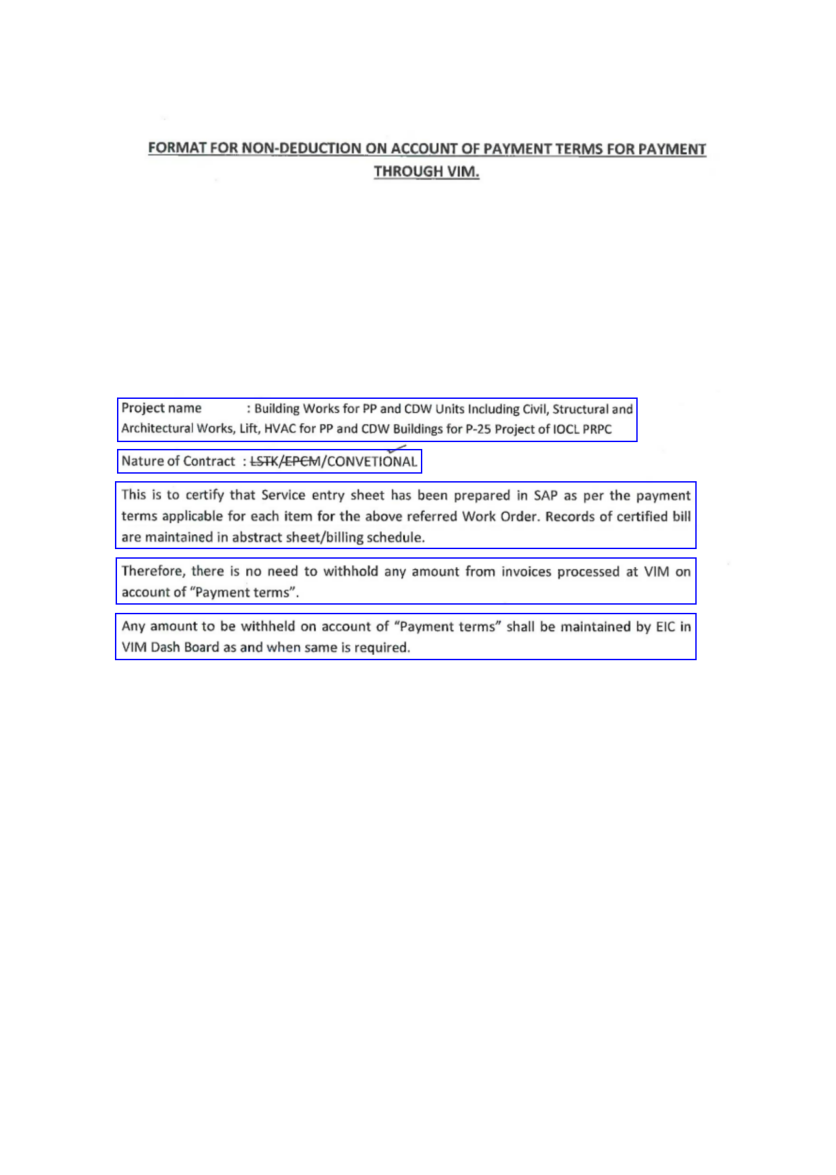

Source 2:
  text: "determined and the amount provisionally withheld. Any excess amount provisionally withheld in excess of Price Adjustment finally determined shall upon such determination be paid to the CONTRACTOR. As an alternative, the CONTRACTOR shall have an option to provide a Bank guarantee from a scheduled bank and in a format acceptable to the OWNER for a su..."
  page: 1
  page: 2
  page: 3


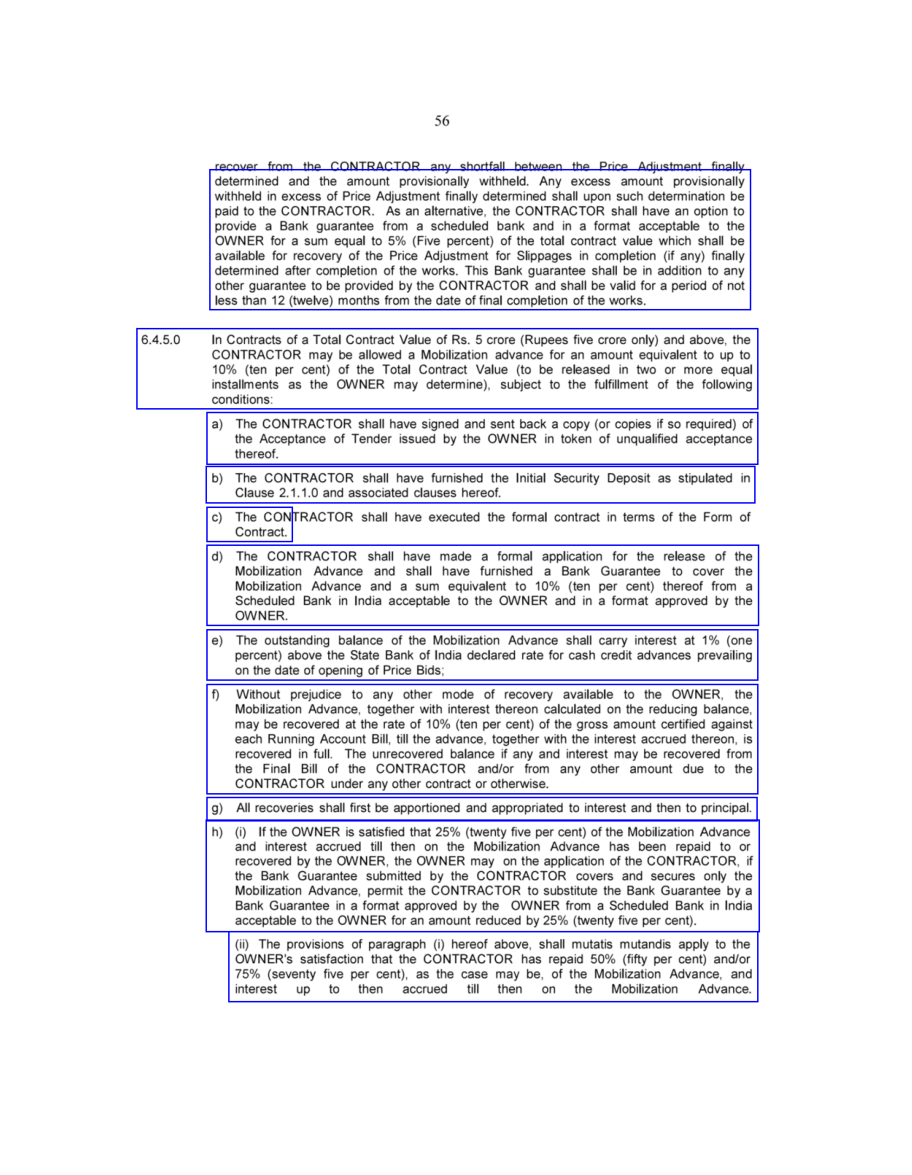

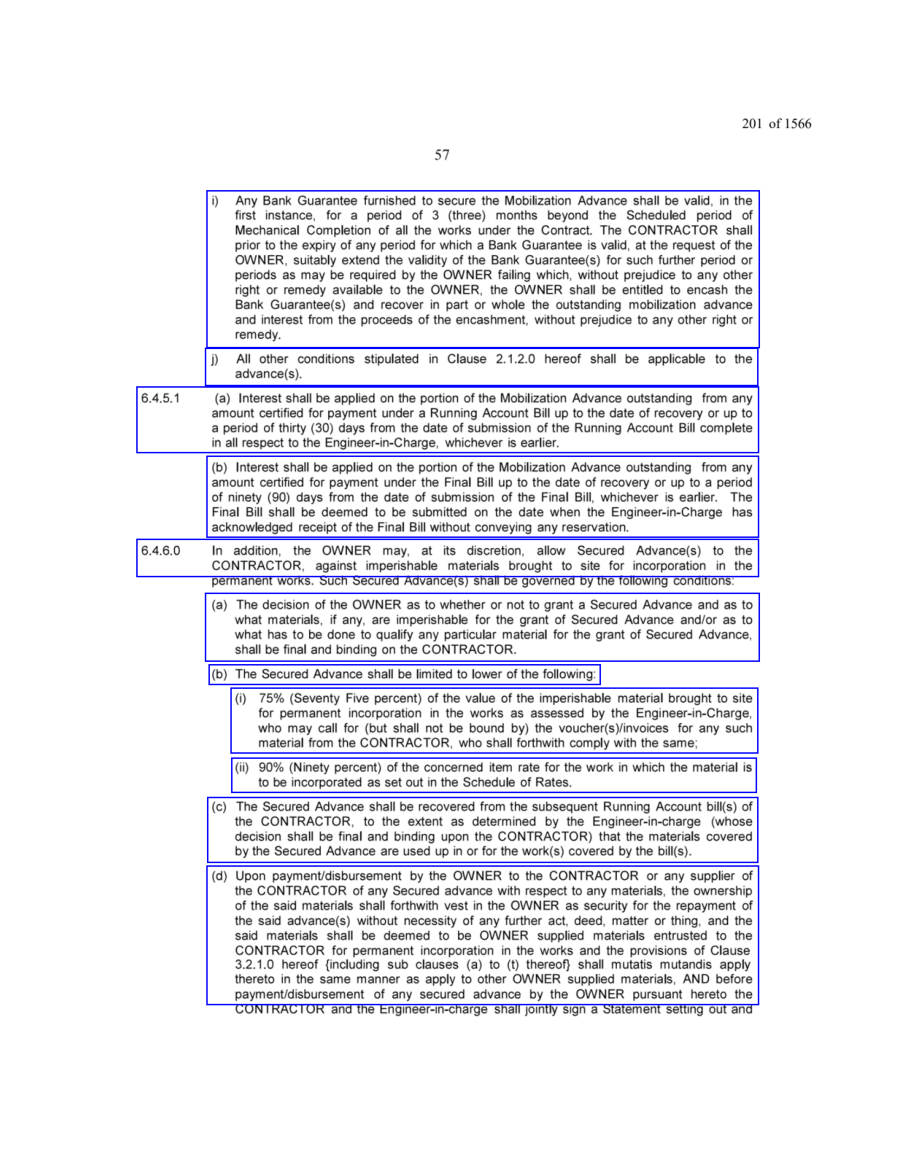

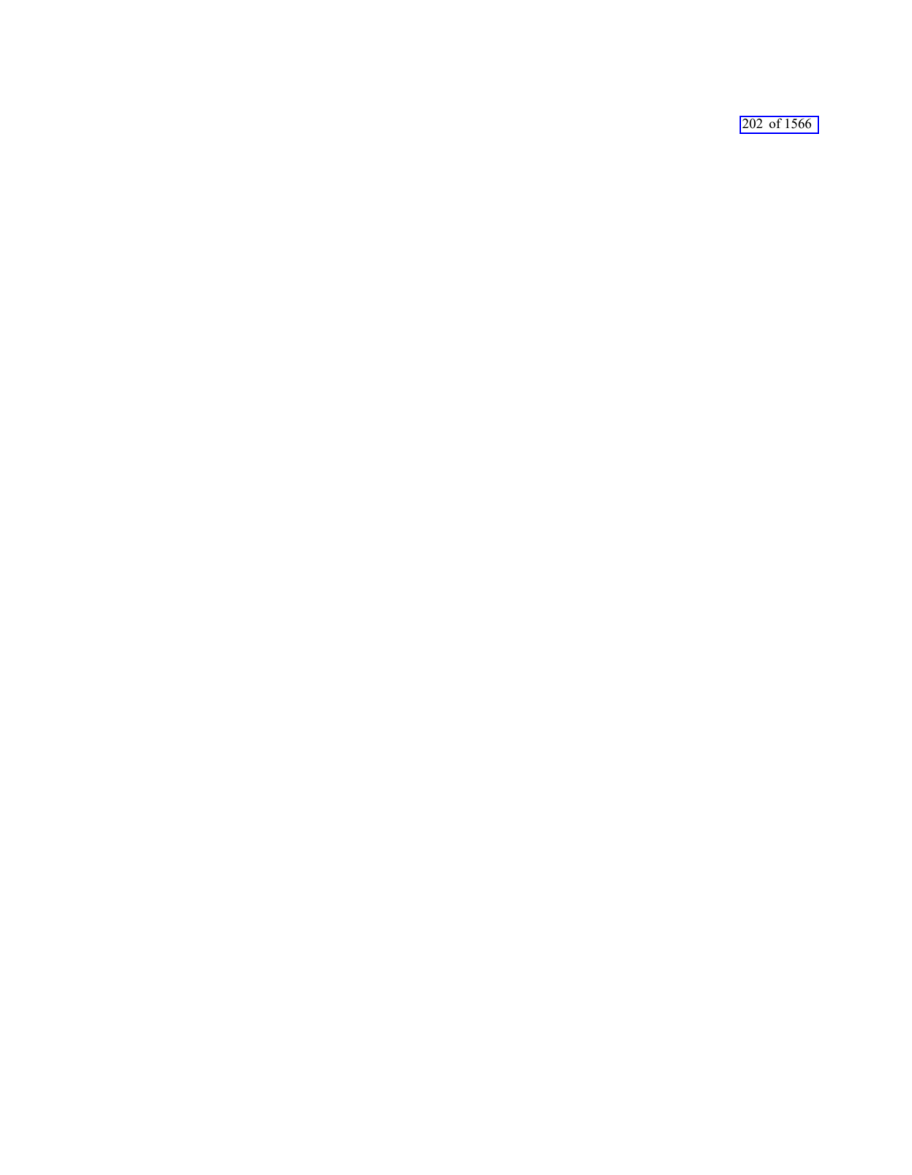

Source 3:
  text: "Notes:\n1. The above payment terms commensurate with the work executed.\n2. The above progress payments are subject to deductions towards income tax and other deductions as applicable as per terms of the Contract.\n3. Withholding Tax  at  the  prevailing  rate  shall  be  deducted  as  per  the  Indian  Income  Tax Act.  TDS certificate shall be issue..."
  page: 15
  page: 16


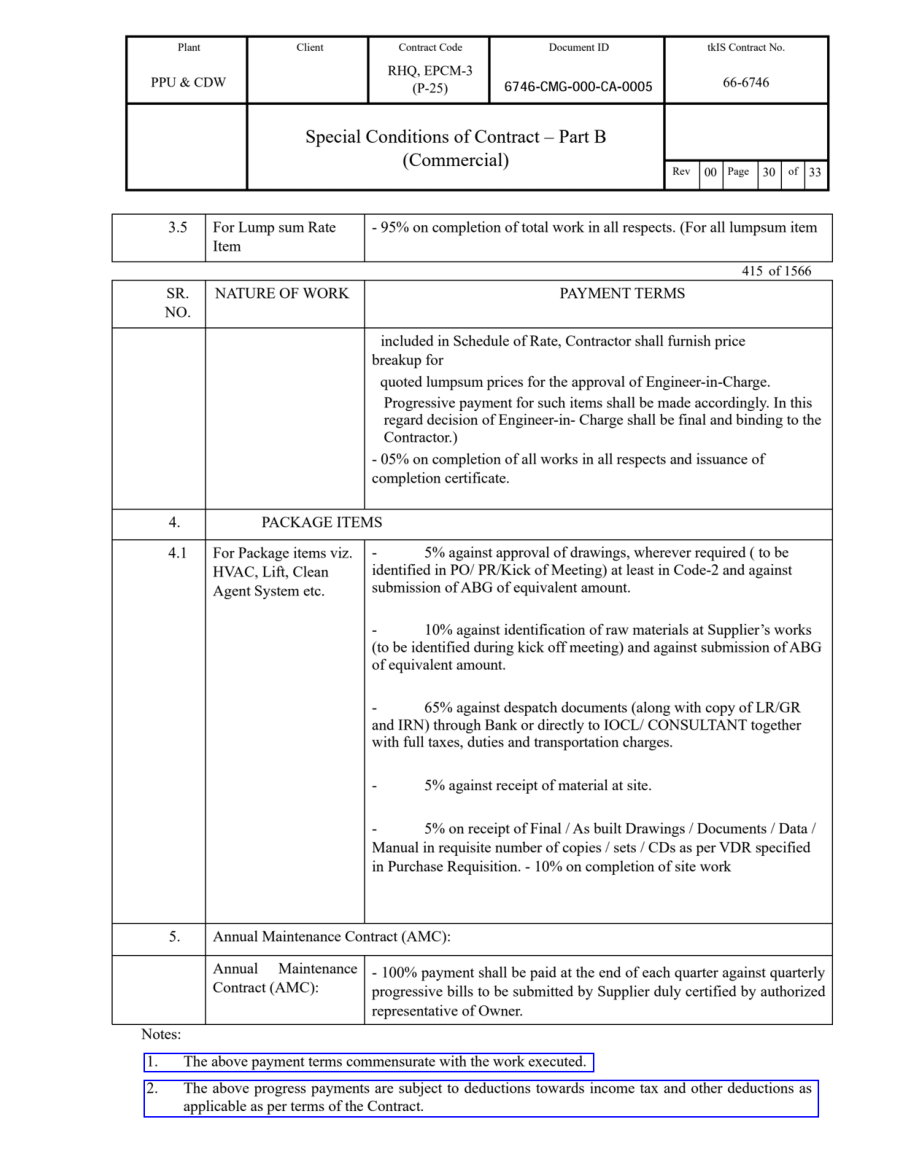

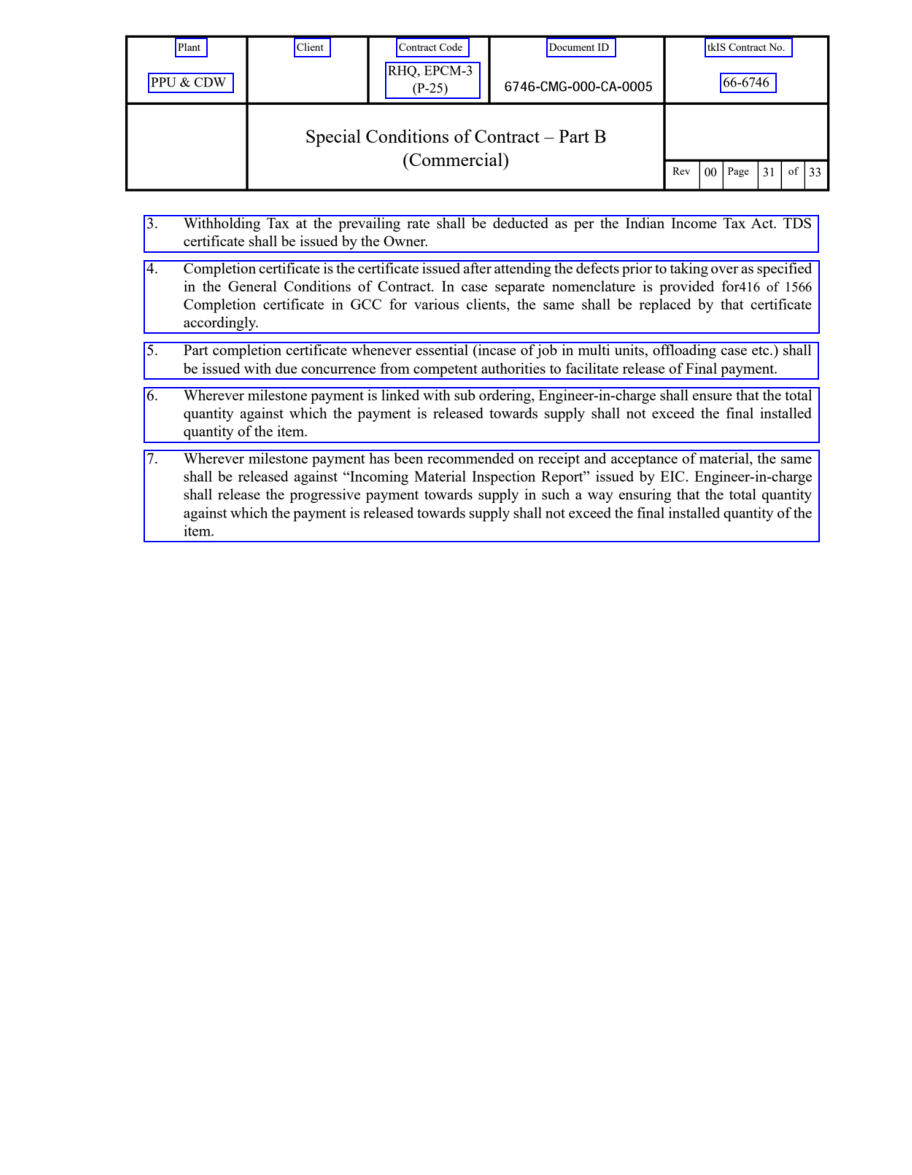

Source 4:
  text: "2.0 ON ACCOUNT PAYMENTS\nProgressive payments shall be released to Contractor against running account bills duly certified by Engineer-in-charge  after  affecting  the  necessary  deductions/recovery,  if  any. The  basis  for  payment against various items shall be as follows:\n1., NATUREOFWORK = CIVIL. 1., PAYMENTTERMS = CIVIL. , NATUREOFWORK = Soi..."
  page: 1
  page: 2
  page: 3
  page: 4


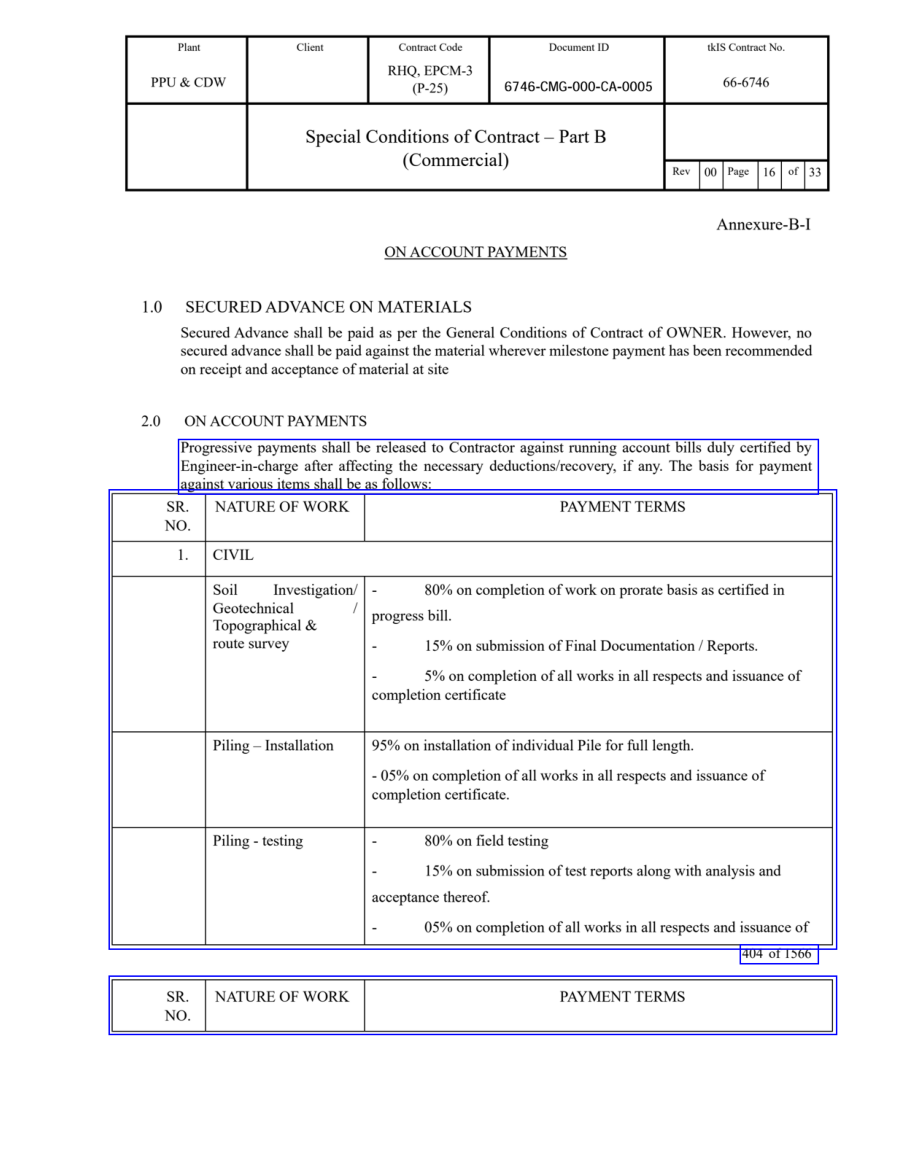

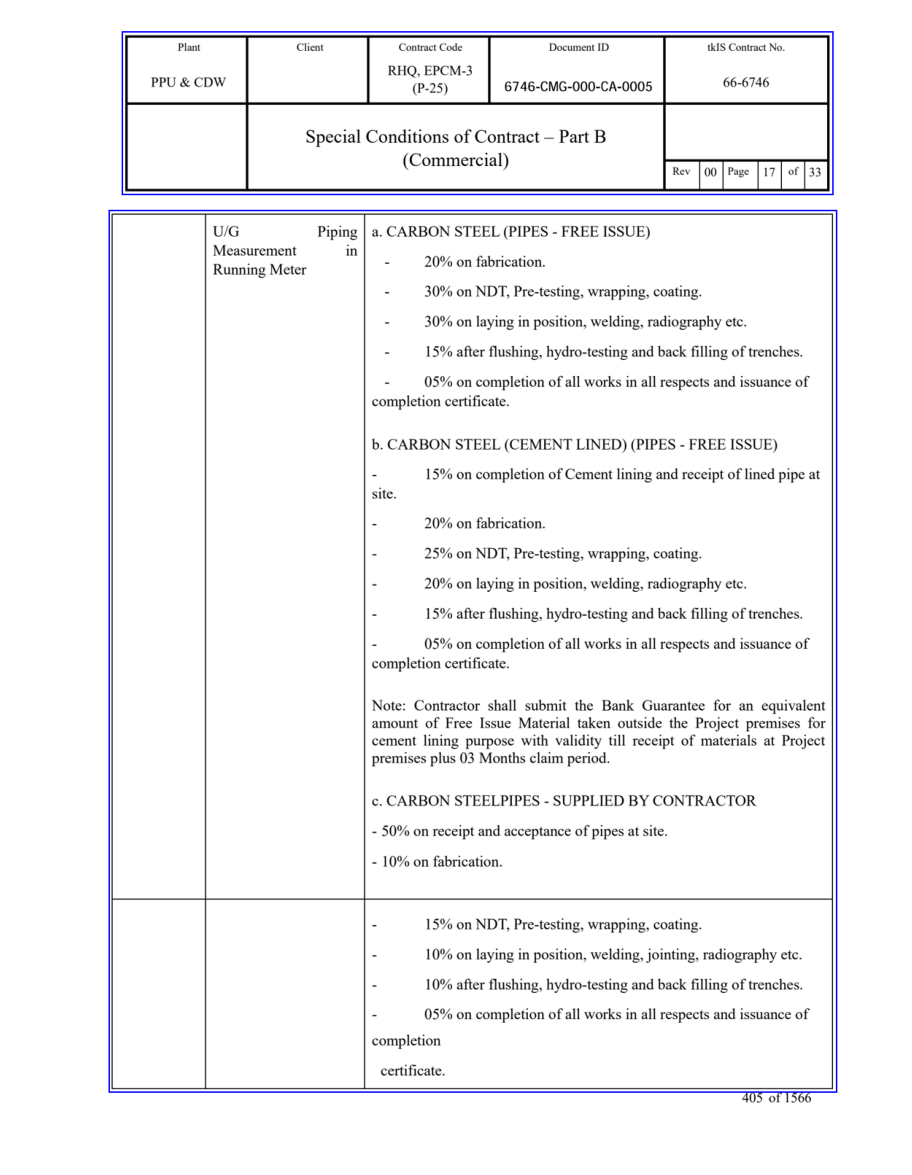

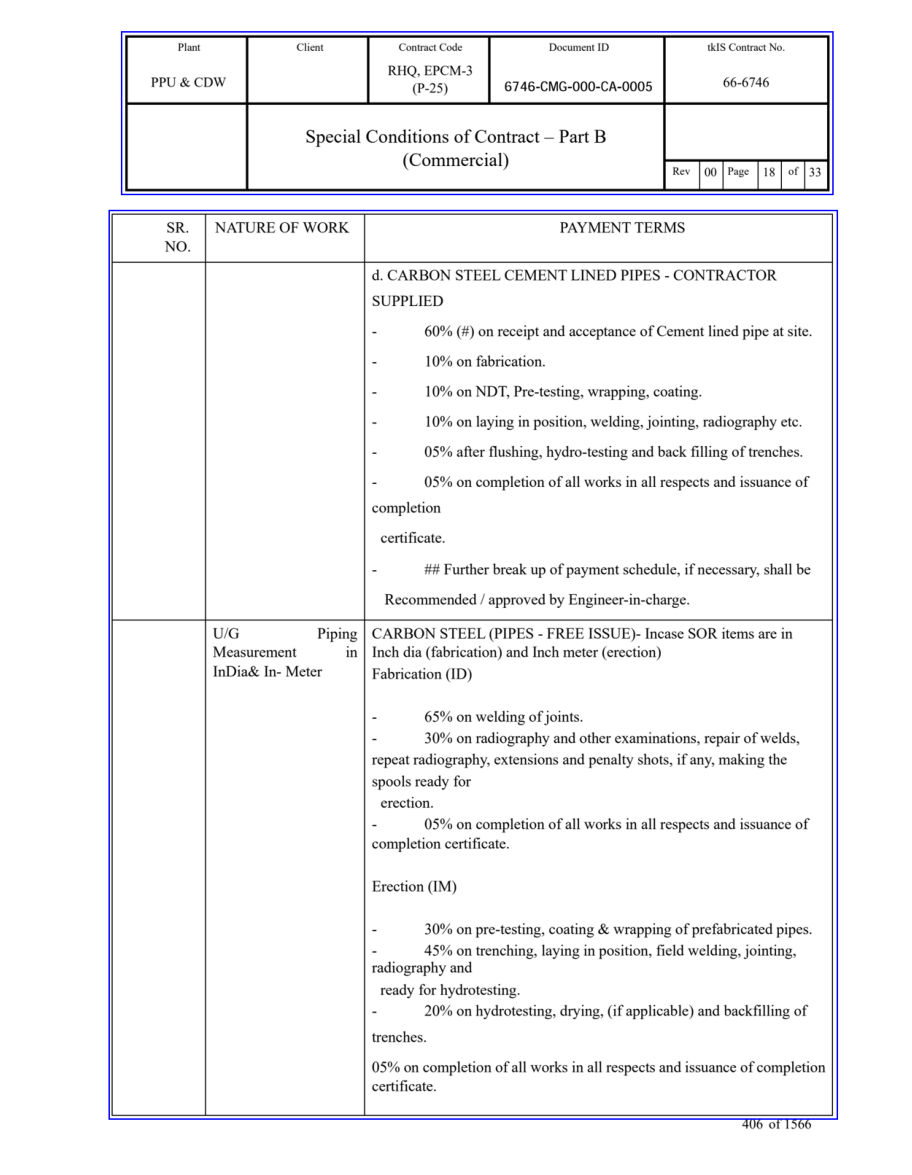

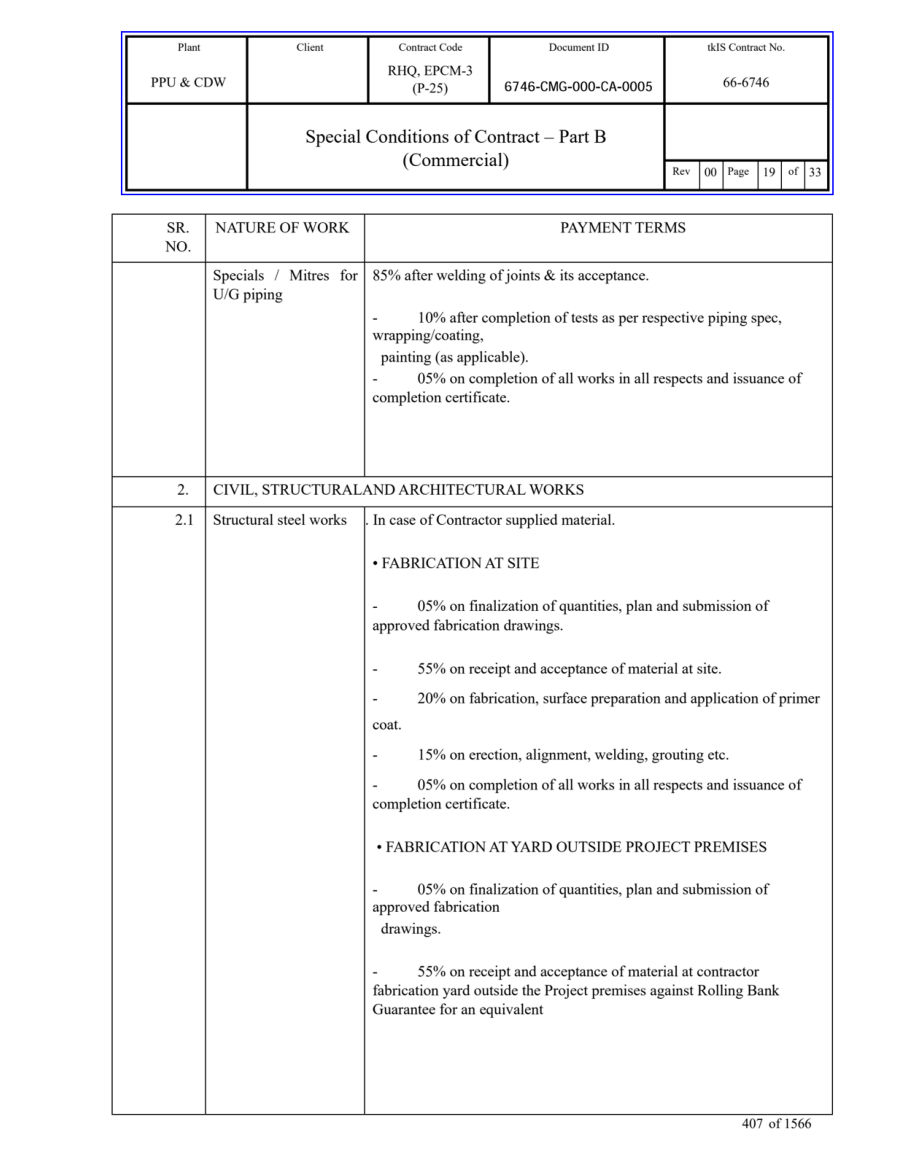

In [58]:
import matplotlib.pyplot as plt
from PIL import ImageDraw

for i, doc in enumerate(resp_dict["context"][:]):
    image_by_page = {}
    print(f"Source {i + 1}:")
    print(f"  text: {json.dumps(clip_text(doc.page_content, threshold=350))}")
    meta = DocMeta.model_validate(doc.metadata["dl_meta"])

    # loading the full DoclingDocument from the document store:
    dl_doc = DoclingDocument.load_from_json(doc_store.get(meta.origin.binary_hash))

    for doc_item in meta.doc_items:
        if doc_item.prov:
            prov = doc_item.prov[0]  # here we only consider the first provenence item
            page_no = prov.page_no
            if img := image_by_page.get(page_no):
                pass
            else:
                page = dl_doc.pages[prov.page_no]
                print(f"  page: {prov.page_no}")
                img = page.image.pil_image
                image_by_page[page_no] = img
            bbox = prov.bbox.to_top_left_origin(page_height=page.size.height)
            bbox = bbox.normalized(page.size)
            thickness = 2
            padding = thickness + 2
            bbox.l = round(bbox.l * img.width - padding)
            bbox.r = round(bbox.r * img.width + padding)
            bbox.t = round(bbox.t * img.height - padding)
            bbox.b = round(bbox.b * img.height + padding)
            draw = ImageDraw.Draw(img)
            draw.rectangle(
                xy=bbox.as_tuple(),
                outline="blue",
                width=thickness,
            )
    for p in image_by_page:
        img = image_by_page[p]
        plt.figure(figsize=[15, 15])
        plt.imshow(img)
        plt.axis("off")
        plt.show()